# MovieLens 100K Recommender System - Phase 3
## Matrix Factorization (SVD, SVD++, NMF, ALS)

**Project:** Hybrid Movie Recommendation System  
**Dataset:** MovieLens 100K  
**Author:** Harpinder Singh  
**Date:** December 2025  
**Best CF RMSE to Beat:** 0.9402

## ╔═══════════════════════════════════════════════════════════╗
## ║                    IMPORTS & SETUP                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy.sparse import csr_matrix

# Surprise library for matrix factorization
from surprise import Dataset, Reader, SVD, SVDpp, NMF
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

# Implicit library for ALS
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split as implicit_split

warnings.filterwarnings('ignore')
np.random.seed(42)

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")
print(f"📅 Execution Date: {datetime.now().strftime('%B %d, %Y')}")

✅ Libraries imported successfully
📅 Execution Date: February 01, 2026


## ╔═══════════════════════════════════════════════════════════╗
## ║                  LOAD PREVIOUS RESULTS                    ║
## ╚═══════════════════════════════════════════════════════════╝

In [16]:
# ┌─────────────────────────────────────────┐
# │ Load Data & Previous Results            │
# └─────────────────────────────────────────┘

data = pd.read_csv('../data/movielens_100k_merged.csv')
cf_results = pd.read_csv('../results/cf_results.csv')

print("📊 Dataset Loaded:")
print(f"   Shape: {data.shape}")

print("\n📊 Previous Best Results (Phase 2):")
print(cf_results.head(3).to_string(index=False))

best_cf_rmse = cf_results['RMSE'].min()
print(f"\n🎯 Target to Beat: RMSE < {best_cf_rmse:.4f}")

📊 Dataset Loaded:
   Shape: (100000, 10)

📊 Previous Best Results (Phase 2):
                  Model     RMSE      MAE
  Item-Based CF (Means) 0.940247 0.739867
Item-Based CF (Z-Score) 0.942329 0.740470
  User-Based CF (Means) 0.953842 0.752562

🎯 Target to Beat: RMSE < 0.9402


In [17]:
# ┌─────────────────────────────────────────┐
# │ Prepare Data for Surprise               │
# └─────────────────────────────────────────┘

reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=42)

print("📊 Data Prepared:")
print(f"   Training samples: {trainset.n_ratings:,}")
print(f"   Test samples:     {len(testset):,}")

📊 Data Prepared:
   Training samples: 80,000
   Test samples:     20,000


## ╔═══════════════════════════════════════════════════════════╗
## ║              SINGULAR VALUE DECOMPOSITION (SVD)           ║
## ╚═══════════════════════════════════════════════════════════╝

In [18]:
# ┌─────────────────────────────────────────┐
# │ SVD - Default Parameters                │
# └─────────────────────────────────────────┘

print("🔢 SVD (Singular Value Decomposition) - Default")
print("=" * 60)

# Train SVD model
svd_default = SVD(random_state=42, verbose=False)
svd_default.fit(trainset)

# Predict on test set
predictions_svd_default = svd_default.test(testset)

# Calculate metrics
rmse_svd_default = accuracy.rmse(predictions_svd_default, verbose=False)
mae_svd_default = accuracy.mae(predictions_svd_default, verbose=False)

print(f"RMSE: {rmse_svd_default:.4f}")
print(f"MAE:  {mae_svd_default:.4f}")
print(f"\nImprovement over best CF: {((best_cf_rmse - rmse_svd_default) / best_cf_rmse * 100):.2f}%")

🔢 SVD (Singular Value Decomposition) - Default
RMSE: 0.9352
MAE:  0.7375

Improvement over best CF: 0.54%


In [19]:
# ┌─────────────────────────────────────────┐
# │ SVD - Hyperparameter Tuning             │
# └─────────────────────────────────────────┘

print("\n🔧 SVD - Hyperparameter Tuning")
print("=" * 60)

# Define parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.05]
}

# Grid search with cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_svd.fit(surprise_data)

# Best parameters
print("\n🏆 Best Parameters:")
print(gs_svd.best_params['rmse'])

# Best scores
print(f"\n📊 Best Cross-Validation RMSE: {gs_svd.best_score['rmse']:.4f}")

# Train best model on full trainset
svd_tuned = gs_svd.best_estimator['rmse']
svd_tuned.fit(trainset)

# Predict on test set
predictions_svd_tuned = svd_tuned.test(testset)

# Calculate metrics
rmse_svd_tuned = accuracy.rmse(predictions_svd_tuned, verbose=False)
mae_svd_tuned = accuracy.mae(predictions_svd_tuned, verbose=False)

print(f"\n📊 Test Set Performance:")
print(f"RMSE: {rmse_svd_tuned:.4f}")
print(f"MAE:  {mae_svd_tuned:.4f}")
print(f"\nImprovement over best CF: {((best_cf_rmse - rmse_svd_tuned) / best_cf_rmse * 100):.2f}%")


🔧 SVD - Hyperparameter Tuning

🏆 Best Parameters:
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}

📊 Best Cross-Validation RMSE: 0.9317

📊 Test Set Performance:
RMSE: 0.9205
MAE:  0.7253

Improvement over best CF: 2.10%


## ╔═══════════════════════════════════════════════════════════╗
## ║                    SVD++ (Enhanced SVD)                   ║
## ╚═══════════════════════════════════════════════════════════╝

In [20]:
# ┌─────────────────────────────────────────┐
# │ SVD++ - With Implicit Feedback          │
# └─────────────────────────────────────────┘

print("\n🔢 SVD++ (SVD with Implicit Feedback)")
print("=" * 60)
print("⚠️  Note: SVD++ is slower but often more accurate\n")

# Train SVD++ model
svdpp_model = SVDpp(random_state=42, verbose=False)
svdpp_model.fit(trainset)

# Predict on test set
predictions_svdpp = svdpp_model.test(testset)

# Calculate metrics
rmse_svdpp = accuracy.rmse(predictions_svdpp, verbose=False)
mae_svdpp = accuracy.mae(predictions_svdpp, verbose=False)

print(f"RMSE: {rmse_svdpp:.4f}")
print(f"MAE:  {mae_svdpp:.4f}")
print(f"\nImprovement over best CF: {((best_cf_rmse - rmse_svdpp) / best_cf_rmse * 100):.2f}%")


🔢 SVD++ (SVD with Implicit Feedback)
⚠️  Note: SVD++ is slower but often more accurate

RMSE: 0.9200
MAE:  0.7198

Improvement over best CF: 2.15%


## ╔═══════════════════════════════════════════════════════════╗
## ║       NON-NEGATIVE MATRIX FACTORIZATION (NMF)            ║
## ╚═══════════════════════════════════════════════════════════╝

In [21]:
# ┌─────────────────────────────────────────┐
# │ NMF - Default Parameters                │
# └─────────────────────────────────────────┘

print("\n🔢 NMF (Non-Negative Matrix Factorization)")
print("=" * 60)

# Train NMF model
nmf_model = NMF(random_state=42, verbose=False)
nmf_model.fit(trainset)

# Predict on test set
predictions_nmf = nmf_model.test(testset)

# Calculate metrics
rmse_nmf = accuracy.rmse(predictions_nmf, verbose=False)
mae_nmf = accuracy.mae(predictions_nmf, verbose=False)

print(f"RMSE: {rmse_nmf:.4f}")
print(f"MAE:  {mae_nmf:.4f}")
print(f"\nImprovement over best CF: {((best_cf_rmse - rmse_nmf) / best_cf_rmse * 100):.2f}%")


🔢 NMF (Non-Negative Matrix Factorization)
RMSE: 0.9594
MAE:  0.7533

Improvement over best CF: -2.04%


## ╔═══════════════════════════════════════════════════════════╗
## ║       ALTERNATING LEAST SQUARES (ALS) - Implicit         ║
## ╚═══════════════════════════════════════════════════════════╝

In [22]:
# ┌─────────────────────────────────────────┐
# │ Prepare Sparse Matrix for ALS          │
# └─────────────────────────────────────────┘

print("\n🔢 ALS (Alternating Least Squares) - Implicit Library")
print("=" * 60)

# Create user-item matrix
train_data_als = data[['user_id', 'item_id', 'rating']].copy()

# Create mappings
user_ids = train_data_als['user_id'].unique()
item_ids = train_data_als['item_id'].unique()

user_map = {uid: idx for idx, uid in enumerate(user_ids)}
item_map = {iid: idx for idx, iid in enumerate(item_ids)}

train_data_als['user_idx'] = train_data_als['user_id'].map(user_map)
train_data_als['item_idx'] = train_data_als['item_id'].map(item_map)

# Create sparse matrix
user_item_matrix = csr_matrix(
    (train_data_als['rating'].values, 
     (train_data_als['user_idx'].values, train_data_als['item_idx'].values)),
    shape=(len(user_ids), len(item_ids))
)

print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Sparsity: {(1 - user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%")


🔢 ALS (Alternating Least Squares) - Implicit Library
User-Item Matrix Shape: (943, 1682)
Sparsity: 93.70%


In [23]:
# ┌─────────────────────────────────────────┐
# │ Train ALS Model                         │
# └─────────────────────────────────────────┘

# Train ALS model
als_model = AlternatingLeastSquares(
    factors=100,
    regularization=0.01,
    iterations=30,
    random_state=42
)

als_model.fit(user_item_matrix)

print("\n✅ ALS model trained successfully")

100%|██████████| 30/30 [00:00<00:00, 105.12it/s]


✅ ALS model trained successfully


In [24]:
# ┌─────────────────────────────────────────┐
# │ Evaluate ALS on Test Set                │
# └─────────────────────────────────────────┘

# Manual test set evaluation (since Surprise testset format differs)
test_predictions_als = []
test_actuals = []

for uid, iid, actual in testset:
    # Map to indices
    if uid in user_map and iid in item_map:
        user_idx = user_map[uid]
        item_idx = item_map[iid]
        
        # Predict
        prediction = als_model.user_factors[user_idx].dot(als_model.item_factors[item_idx])
        
        # Clip to rating scale
        prediction = np.clip(prediction, 1, 5)
        
        test_predictions_als.append(prediction)
        test_actuals.append(actual)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_als = sqrt(mean_squared_error(test_actuals, test_predictions_als))
mae_als = mean_absolute_error(test_actuals, test_predictions_als)

print(f"\n📊 ALS Performance:")
print(f"RMSE: {rmse_als:.4f}")
print(f"MAE:  {mae_als:.4f}")
print(f"\nImprovement over best CF: {((best_cf_rmse - rmse_als) / best_cf_rmse * 100):.2f}%")


📊 ALS Performance:
RMSE: 2.7473
MAE:  2.5061

Improvement over best CF: -192.19%


## ╔═══════════════════════════════════════════════════════════╗
## ║          COMPARE ALL MATRIX FACTORIZATION MODELS         ║
## ╚═══════════════════════════════════════════════════════════╝

In [25]:
# ┌─────────────────────────────────────────┐
# │ Compile All MF Results                  │
# └─────────────────────────────────────────┘

mf_results = pd.DataFrame({
    'Model': [
        'Best CF (Item-Based Means)',
        'SVD (Default)',
        'SVD (Tuned)',
        'SVD++',
        'NMF',
        'ALS'
    ],
    'RMSE': [
        best_cf_rmse,
        rmse_svd_default,
        rmse_svd_tuned,
        rmse_svdpp,
        rmse_nmf,
        rmse_als
    ],
    'MAE': [
        cf_results.loc[cf_results['RMSE'].idxmin(), 'MAE'],
        mae_svd_default,
        mae_svd_tuned,
        mae_svdpp,
        mae_nmf,
        mae_als
    ]
})

# Sort by RMSE
mf_results = mf_results.sort_values('RMSE').reset_index(drop=True)

print("\n📊 MATRIX FACTORIZATION RESULTS")
print("=" * 70)
print(mf_results.to_string(index=False))

# Save results
mf_results.to_csv('../results/mf_results.csv', index=False)
print("\n💾 Results saved to: mf_results.csv")


📊 MATRIX FACTORIZATION RESULTS
                     Model     RMSE      MAE
                     SVD++ 0.919991 0.719777
               SVD (Tuned) 0.920503 0.725251
             SVD (Default) 0.935171 0.737509
Best CF (Item-Based Means) 0.940247 0.739867
                       NMF 0.959408 0.753335
                       ALS 2.747263 2.506133

💾 Results saved to: mf_results.csv


In [26]:
# ┌─────────────────────────────────────────┐
# │ Best Model Identification               │
# └─────────────────────────────────────────┘

best_mf_idx = mf_results['RMSE'].idxmin()
best_mf_name = mf_results.loc[best_mf_idx, 'Model']
best_mf_rmse = mf_results.loc[best_mf_idx, 'RMSE']
best_mf_mae = mf_results.loc[best_mf_idx, 'MAE']

improvement_over_cf = ((best_cf_rmse - best_mf_rmse) / best_cf_rmse) * 100

print(f"\n🏆 BEST MODEL: {best_mf_name}")
print("=" * 70)
print(f"   RMSE:                    {best_mf_rmse:.4f}")
print(f"   MAE:                     {best_mf_mae:.4f}")
print(f"   Previous Best (CF):      {best_cf_rmse:.4f}")
print(f"   Improvement:             {improvement_over_cf:.2f}%")


🏆 BEST MODEL: SVD++
   RMSE:                    0.9200
   MAE:                     0.7198
   Previous Best (CF):      0.9402
   Improvement:             2.15%


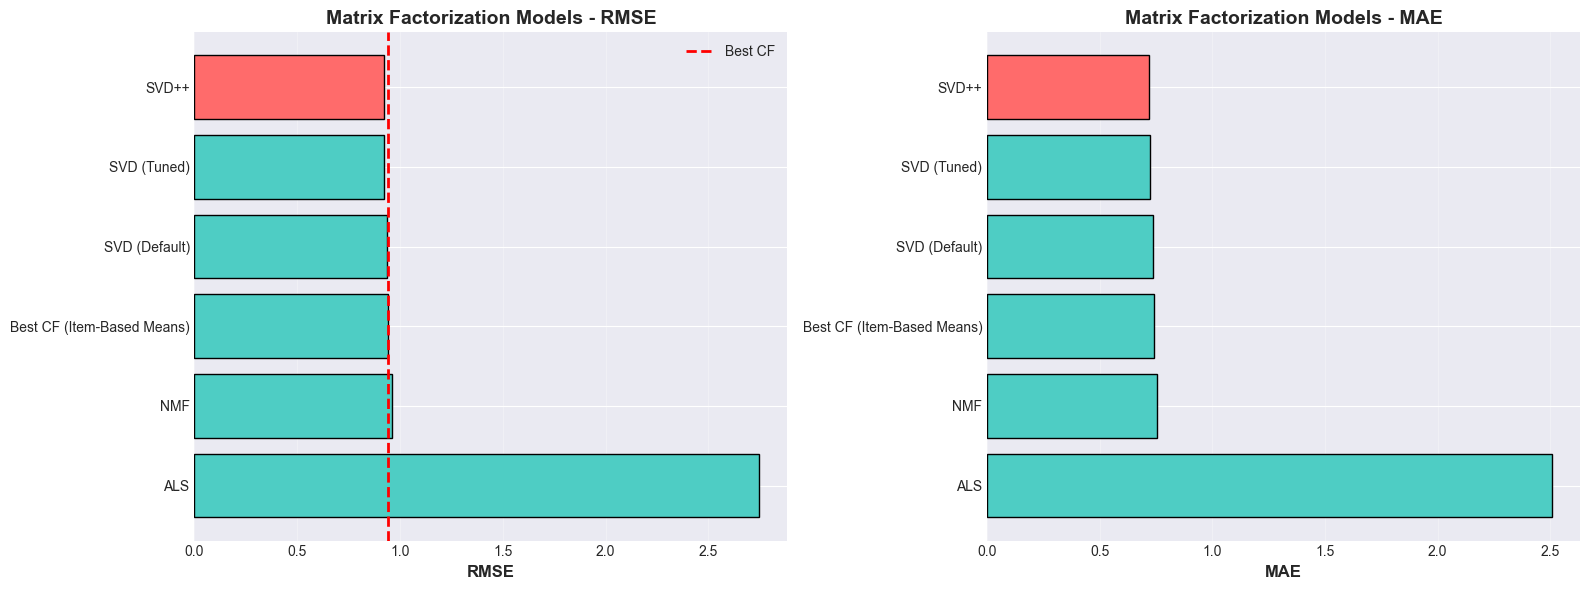

In [27]:
# ┌─────────────────────────────────────────┐
# │ Visualize MF Model Comparison           │
# └─────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
colors = ['#FF6B6B' if i == 0 else '#4ECDC4' for i in range(len(mf_results))]
axes[0].barh(mf_results['Model'], mf_results['RMSE'], color=colors, edgecolor='black')
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Matrix Factorization Models - RMSE', fontsize=14, fontweight='bold')
axes[0].axvline(best_cf_rmse, color='red', linestyle='--', linewidth=2, label='Best CF')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(mf_results['Model'], mf_results['MAE'], color=colors, edgecolor='black')
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Matrix Factorization Models - MAE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../results/visualizations/09_mf_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

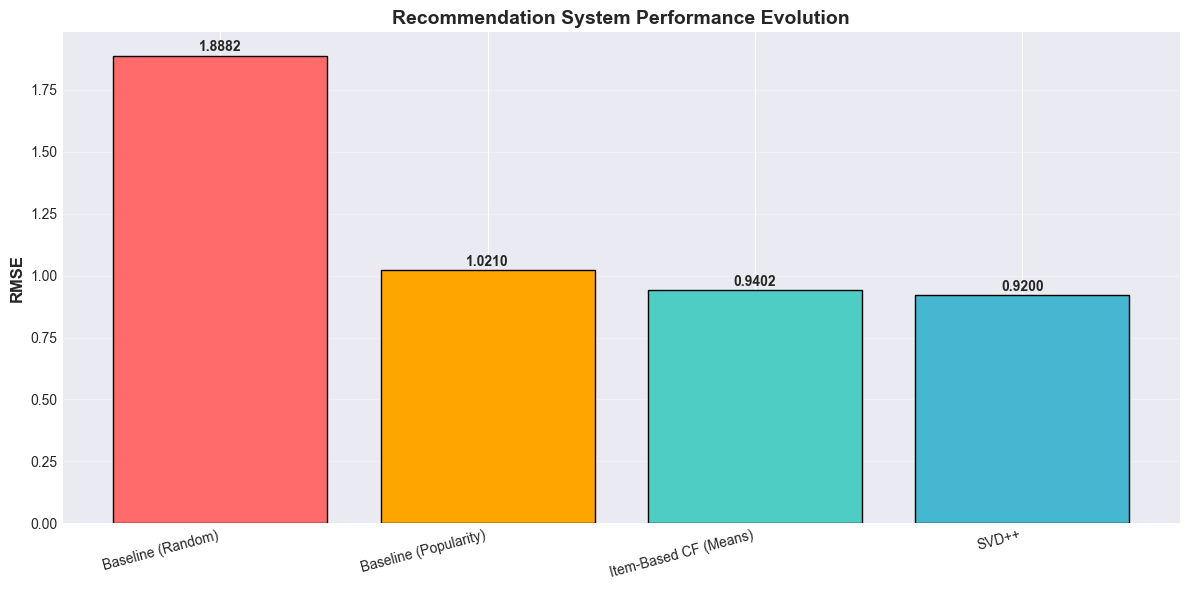


📊 Overall Performance Improvement:
   From Random Baseline: 1.8882 → 0.9200
   Total Improvement:    51.28%


In [28]:
# ┌─────────────────────────────────────────┐
# │ Overall Progress Visualization          │
# └─────────────────────────────────────────┘

# Combine all results
baseline_results = pd.read_csv('../results/baseline_results.csv')

all_models = [
    ('Baseline (Random)', baseline_results[baseline_results['Model'] == 'Random']['RMSE'].values[0]),
    ('Baseline (Popularity)', baseline_results[baseline_results['Model'] == 'Popularity-Based']['RMSE'].values[0]),
    ('Item-Based CF (Means)', best_cf_rmse),
    (best_mf_name, best_mf_rmse)
]

models_df = pd.DataFrame(all_models, columns=['Model', 'RMSE'])

plt.figure(figsize=(12, 6))
colors_progress = ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']
plt.bar(models_df['Model'], models_df['RMSE'], color=colors_progress, edgecolor='black')
plt.ylabel('RMSE', fontsize=12, fontweight='bold')
plt.title('Recommendation System Performance Evolution', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(models_df['RMSE']):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/visualizations/10_overall_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Overall Performance Improvement:")
initial_rmse = baseline_results[baseline_results['Model'] == 'Random']['RMSE'].values[0]
final_improvement = ((initial_rmse - best_mf_rmse) / initial_rmse) * 100
print(f"   From Random Baseline: {initial_rmse:.4f} → {best_mf_rmse:.4f}")
print(f"   Total Improvement:    {final_improvement:.2f}%")

## ╔═══════════════════════════════════════════════════════════╗
## ║                  PHASE 3 SUMMARY                          ║
## ╚═══════════════════════════════════════════════════════════╝

In [29]:
print("="*70)
print("                 PHASE 3 COMPLETE ✅")
print("="*70)
print("\n📦 DELIVERABLES:")
print("   ✅ 5 Matrix Factorization models trained")
print("   ✅ SVD (Default + Tuned)")
print("   ✅ SVD++ (with implicit feedback)")
print("   ✅ NMF (Non-negative Matrix Factorization)")
print("   ✅ ALS (Alternating Least Squares)")
print("   ✅ 2 visualizations saved (09-10.png)")
print("   ✅ MF results saved (mf_results.csv)")

print("\n📊 KEY RESULTS:")
print(f"   • Best MF Model:         {best_mf_name}")
print(f"   • Best RMSE:             {best_mf_rmse:.4f}")
print(f"   • Previous Best (CF):    {best_cf_rmse:.4f}")
print(f"   • Improvement:           {improvement_over_cf:.2f}%")

print("\n🎯 NEXT STEPS:")
print("   → Phase 4: Content-Based Filtering (Genre TF-IDF)")
print("   → Phase 5: Hybrid Models (Combine CF + Content + MF)")
print("   → Phase 6: Cold Start Handling & Final Evaluation")
print("\n" + "="*70)

                 PHASE 3 COMPLETE ✅

📦 DELIVERABLES:
   ✅ 5 Matrix Factorization models trained
   ✅ SVD (Default + Tuned)
   ✅ SVD++ (with implicit feedback)
   ✅ NMF (Non-negative Matrix Factorization)
   ✅ ALS (Alternating Least Squares)
   ✅ 2 visualizations saved (09-10.png)
   ✅ MF results saved (mf_results.csv)

📊 KEY RESULTS:
   • Best MF Model:         SVD++
   • Best RMSE:             0.9200
   • Previous Best (CF):    0.9402
   • Improvement:           2.15%

🎯 NEXT STEPS:
   → Phase 4: Content-Based Filtering (Genre TF-IDF)
   → Phase 5: Hybrid Models (Combine CF + Content + MF)
   → Phase 6: Cold Start Handling & Final Evaluation

